<a href="https://colab.research.google.com/github/Gyeong-Hyeon/TOXIC_SPEECH_DETECTION/blob/main/Contextdata_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install -q --upgrade ipython==5.5.0
!pip install -q --upgrade ipykernel==4.10

In [ ]:
#Pytorch TPU setting

!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

In [ ]:
import gc
import os
import time
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

import datetime
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torch_xla
import torch_xla.core.xla_model as xm
device = xm.xla_device() 


from torch import Tensor
from torch.optim import Adam, AdamW
import torch.utils.data as D
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import *
from sklearn.model_selection import train_test_split, StratifiedKFold

In [ ]:
context = pd.read_csv('/content/drive/MyDrive/finalproject/finaldata/context_ver2.csv')
context = context.dropna()
context = context[~(context.duplicated())]

context

,target,cleaned_comment
0,0.0,"['what be thomas dorsey know for', 'have never..."
1,0.0,['if same asteroid that kill dinosaur be come ...
2,0.0,['be there any country in world that have smal...
3,0.0,"['why do narcissist ex want to destroy you', '..."
4,0.0,"['how do dance come to be', 'have never think ..."
...,...,...
25676,1.0,"['take it to talk page this isn venue', 'no be..."
25677,1.0,['netto be place to go shop all day shop all n...
25678,1.0,['p thomas mcpherson brown article lack suitab...
25679,1.0,['all of his arguements be nail perfect you re...


In [ ]:
max_len = max(len(comment.split()) for comment in context.cleaned_comment)
max_len = max_len + 3
max_len

419

In [ ]:
context['cleaned_comment'] = context['cleaned_comment'].apply(lambda x: ast.literal_eval(x))
print(type(context['cleaned_comment'][0]))
print(type(context['cleaned_comment'][0][0]))

<class 'list'>
<class 'str'>


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech")

# context['token'] = context['cleaned_comment'].apply(lambda x: tokenizer([x[0]],[x[1]], max_length=max_len, pad_to_max_length=True, return_token_type_ids=False))
# context['token'][0]

In [ ]:
for ids in context['token'][0]['input_ids']:
    print(tokenizer.decode(ids))

<s>what was thomas dorsey known for</s></s>have never think about that</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [ ]:
np.array(context['token'][0]['input_ids']).shape

(1, 425)

In [ ]:
epochs = 50
batch_size = 32
warmup_prop = 0.1
lr = 1e-4

##K Flod (Failed)

In [ ]:
#For K Fold
X_train, X_test, y_train, y_test = train_test_split(context['token'], context['target'], test_size=0.1, random_state=10, shuffle=True)

X_train.shape, X_test.shape

((22796,), (2533,))

In [ ]:
# K-Fold spliter
num_bins = int(np.floor(1 + np.log2(X_train.shape[0])))
y = pd.cut(y_train, bins=num_bins, labels=False)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

In [ ]:
class LitDataset(D.Dataset):
    
    def __init__(self, token, target):
        self.token = token
        self.target = target
        
    def __len__(self):
        return self.token.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.token.iloc[idx].input_ids[0]), torch.tensor(self.token.iloc[idx].attention_mask[0]), torch.tensor(self.target.values[idx])
    
def collate_fn(batch):
    ids, attns, targets = zip(*batch)
    ids = ids.to(device)
    attns = attns.to(device)
    targets = targets.to(device)
    targets = torch.tensor(targets).float()
    return ids, attns, targets

def collate_fn_test(batch):
    ids, attns, idxs = zip(*batch)
    return idxs, ids, attns

In [ ]:
ds = LitDataset(X_train, y_train)

In [ ]:
import torch_xla
import torch_xla.core.xla_model as xm

@torch.no_grad()
def validation_fn(model, loader):
    tloss = 0
    pred = []
    truths = [] 
    model.eval();
    for _, batch in tqdm(loader, total=len(loader), desc="validation" ):
        batch = tuple(t.to(device) for t in batch)
        texts, attns, target = batch
        outputs = model(texts, token_type_ids=None, attention_mask=attns, labels=target)
        
        loss, output = outputs

        tloss += loss.item() / len(loader)
        pred.extend(torch.argmax(output.flatten(), 1).tolist())
        truths.extend(target.tolist())

    score = roc_auc_score(truths, preds)

    return tloss, score

def oof_train(ds, cv, y, epochs = epochs):
    
    for fold, (train_idx, valid_idx) in enumerate(cv.split(range(len(ds)), y)):
        
        train_ds = D.Subset(ds, train_idx)
        loader = D.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        
        valid_ds = D.Subset(ds, valid_idx)
        vloader = D.DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
        
        model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech")
        model = model.to(device)
        
        optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-1)
        num_warmup_steps = int(warmup_prop * epochs * len(loader))
        num_training_steps = epochs * len(loader)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
        print('Starting fold',fold)

        for epoch in tqdm(range(1, epochs+1), desc="Epoch"):      
            model.train()
            start_time = time.time()
            tloss = 0
            pred = []
            truths = []         
            
            for _, batch in tqdm(enumerate(loader), total=len(loader), desc="Iteration"):
                batch = tuple(t.to(device) for t in batch)
                texts, attns, target = batch
                print(target.unsqueeze(1))
                
                outputs = model(texts, token_type_ids=None, attention_mask=attns, labels=target.unsqueeze(1))
                                
                loss, output = outputs
                tloss += loss.item()
                pred.extend(torch.argmax(output.flatten(), 1).tolist())
                truths.extend(target.tolist())

                loss.backward()
                optimizer.zero_grad()
                xm.optimizer_step(optimizer, barrier=True)
                scheduler.step()

            t_loss = tloss / len(loader)
            t_score = roc_auc_score(truths, preds)
            v_loss, v_score = validation_fn(model, vloader)
            
            #save model on every epoch
            output_dir = os.path.join('/content/drive/MyDrive/finalproject/context', f'F-{fold}-E-{epoch}-VL-{vloss:.4f}')
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            model.save_pretrained(output_dir)
            print(f"Saving model checkpoint to {output_dir}")
            
            print(f'Epoch {epoch + 1}/{epochs} \t t={dt/60:.0f}min \t loss={t_loss:.4f} \t train_auc={t_score:.4f} \t val_loss={v_loss:.4f} \t val_auc={v_score:.4f}')
        del model, vloader, loader, train_ds, valid_ds

In [ ]:
oof_train(ds, cv, y, epochs = epochs)

Starting fold 0


tensor([[1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
         1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.]],
       device='xla:1', dtype=torch.float64)


ValueError: ignored

## Holdout validation

In [ ]:
#For Hold out validation
X_train, X_test, y_train, y_test = train_test_split(context['cleaned_comment'], context['target'], test_size=0.2, random_state=10, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.4, random_state=10, shuffle=True)

X_train.shape, X_val.shape, X_test.shape

((20263,), (3039,), (2027,))

In [ ]:
def encode(text):
    return tokenizer(text, max_length=max_len, pad_to_max_length=True, return_token_type_ids=False)

def torch_dataset(X,y):
    id = torch.tensor([data['input_ids'][0] for data in X], dtype=torch.long)
    mask = torch.tensor([data['attention_mask'][0] for data in X], dtype=torch.long)
    label = torch.tensor(y.values, dtype=torch.long)
    return D.TensorDataset(id, mask, label)

# train = torch_dataset(X_train.map(encode), y_train)
# val = torch_dataset(X_val.map(encode), y_val)
# train_loader = D.DataLoader(train, shuffle=True, batch_size=batch_size)
# val_loader = D.DataLoader(val, shuffle=False, batch_size=batch_size)

In [ ]:
import torch_xla
import torch_xla.core.xla_model as xm

@torch.no_grad()
def validation_fn(model, loader):
    tloss = 0
    pred = []
    truths = [] 
    model.eval();
    for _, batch in tqdm(enumerate(loader), total=len(loader), desc="validation" ):
        batch = tuple(t.to(device) for t in batch)
        texts, attns, target = batch
        outputs = model(texts, token_type_ids=None, attention_mask=attns, labels=target)
        
        loss, logits = outputs

        tloss += loss.item() / len(loader)
        pred.extend(torch.argmax(logits, 1).tolist())
        truths.extend(target.tolist())

    score = roc_auc_score(truths, pred)

    return tloss, score

def train(model, loader, vloader, epochs, batch_size, warmup_prop, lr):      
    model = model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-1)
    num_warmup_steps = int(warmup_prop * epochs * len(loader))
    num_training_steps = epochs * len(loader)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

    for epoch in tqdm(range(1, epochs+1), desc="Epoch"):      
        model.train()
        start_time = time.time()
        tloss = 0
        pred = []
        truths = []         
        
        for _, batch in tqdm(enumerate(loader), total=len(loader), desc="Iteration"):
            batch = tuple(t.to(device) for t in batch)
            texts, attns, target = batch
            
            outputs = model(texts, token_type_ids=None, attention_mask=attns, labels=target)
                            
            loss, logits = outputs
            tloss += loss.item()
            pred.extend(torch.argmax(logits, 1).tolist())
            truths.extend(target.tolist())

            loss.backward()
            optimizer.zero_grad()
            xm.optimizer_step(optimizer, barrier=True)
            scheduler.step()

        t_loss = tloss / len(loader)
        t_score = roc_auc_score(truths, pred)
        v_loss, v_score = validation_fn(model, vloader)
        dt = time.time() - start_time
        #save model on every epoch
        output_dir = os.path.join('/content/drive/MyDrive/finalproject/context_2', f'E-{epoch}-VL-{v_loss:.4f}')
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model.save_pretrained(output_dir)
        print(f"Saving model checkpoint to {output_dir}")
        
        print(f'Epoch {epoch}/{epochs} \t t={dt/60:.0f}min \t loss={t_loss:.4f} \t train_auc={t_score:.4f} \t val_loss={v_loss:.4f} \t val_auc={v_score:.4f}')

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech", return_dict=False)

In [ ]:
train(model, train_loader, val_loader, epochs, batch_size, warmup_prop, lr)


Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-1-VL-1.6433
Epoch 1/50 	 t=30min 	 loss=1.5853 	 train_auc=0.5952 	 val_loss=1.6433 	 val_auc=0.6126



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-2-VL-1.6273
Epoch 2/50 	 t=7min 	 loss=1.5844 	 train_auc=0.5971 	 val_loss=1.6273 	 val_auc=0.6129



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-3-VL-1.6044
Epoch 3/50 	 t=7min 	 loss=1.5660 	 train_auc=0.5973 	 val_loss=1.6044 	 val_auc=0.6132



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-4-VL-1.5808
Epoch 4/50 	 t=11min 	 loss=1.5471 	 train_auc=0.5986 	 val_loss=1.5808 	 val_auc=0.6149



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-5-VL-1.5378
Epoch 5/50 	 t=7min 	 loss=1.5144 	 train_auc=0.6005 	 val_loss=1.5378 	 val_auc=0.6142



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-6-VL-1.4987
Epoch 6/50 	 t=7min 	 loss=1.4796 	 train_auc=0.6006 	 val_loss=1.4987 	 val_auc=0.6139



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-7-VL-1.4582
Epoch 7/50 	 t=7min 	 loss=1.4417 	 train_auc=0.5985 	 val_loss=1.4582 	 val_auc=0.6145



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-8-VL-1.4146
Epoch 8/50 	 t=7min 	 loss=1.4143 	 train_auc=0.6018 	 val_loss=1.4146 	 val_auc=0.6158



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-9-VL-1.3748
Epoch 9/50 	 t=7min 	 loss=1.3817 	 train_auc=0.6012 	 val_loss=1.3748 	 val_auc=0.6175



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-10-VL-1.3371
Epoch 10/50 	 t=7min 	 loss=1.3467 	 train_auc=0.6025 	 val_loss=1.3371 	 val_auc=0.6165



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-11-VL-1.3003
Epoch 11/50 	 t=7min 	 loss=1.3199 	 train_auc=0.6038 	 val_loss=1.3003 	 val_auc=0.6178



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-12-VL-1.2665
Epoch 12/50 	 t=7min 	 loss=1.2805 	 train_auc=0.6045 	 val_loss=1.2665 	 val_auc=0.6178



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-13-VL-1.2333
Epoch 13/50 	 t=7min 	 loss=1.2627 	 train_auc=0.6017 	 val_loss=1.2333 	 val_auc=0.6177



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-14-VL-1.2049
Epoch 14/50 	 t=7min 	 loss=1.2322 	 train_auc=0.6033 	 val_loss=1.2049 	 val_auc=0.6167



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-15-VL-1.1758
Epoch 15/50 	 t=7min 	 loss=1.2052 	 train_auc=0.6020 	 val_loss=1.1758 	 val_auc=0.6180



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-16-VL-1.1486
Epoch 16/50 	 t=7min 	 loss=1.1812 	 train_auc=0.6014 	 val_loss=1.1486 	 val_auc=0.6180



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-17-VL-1.1257
Epoch 17/50 	 t=7min 	 loss=1.1551 	 train_auc=0.6038 	 val_loss=1.1257 	 val_auc=0.6193



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-18-VL-1.1017
Epoch 18/50 	 t=7min 	 loss=1.1370 	 train_auc=0.6042 	 val_loss=1.1017 	 val_auc=0.6170



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-19-VL-1.0823
Epoch 19/50 	 t=7min 	 loss=1.1193 	 train_auc=0.6000 	 val_loss=1.0823 	 val_auc=0.6167



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-20-VL-1.0610
Epoch 20/50 	 t=7min 	 loss=1.1060 	 train_auc=0.5985 	 val_loss=1.0610 	 val_auc=0.6173



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-21-VL-1.0448
Epoch 21/50 	 t=7min 	 loss=1.0812 	 train_auc=0.5999 	 val_loss=1.0448 	 val_auc=0.6173



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-22-VL-1.0245
Epoch 22/50 	 t=7min 	 loss=1.0672 	 train_auc=0.5993 	 val_loss=1.0245 	 val_auc=0.6160



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-23-VL-1.0113
Epoch 23/50 	 t=7min 	 loss=1.0512 	 train_auc=0.5975 	 val_loss=1.0113 	 val_auc=0.6166



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-24-VL-0.9935
Epoch 24/50 	 t=7min 	 loss=1.0388 	 train_auc=0.5984 	 val_loss=0.9935 	 val_auc=0.6159



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-25-VL-0.9790
Epoch 25/50 	 t=7min 	 loss=1.0207 	 train_auc=0.5986 	 val_loss=0.9790 	 val_auc=0.6152



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-26-VL-0.9624
Epoch 26/50 	 t=7min 	 loss=1.0109 	 train_auc=0.5964 	 val_loss=0.9624 	 val_auc=0.6162



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-27-VL-0.9513
Epoch 27/50 	 t=11min 	 loss=1.0011 	 train_auc=0.5971 	 val_loss=0.9513 	 val_auc=0.6146



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-28-VL-0.9366
Epoch 28/50 	 t=7min 	 loss=0.9904 	 train_auc=0.5937 	 val_loss=0.9366 	 val_auc=0.6149



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-29-VL-0.9272
Epoch 29/50 	 t=7min 	 loss=0.9799 	 train_auc=0.5941 	 val_loss=0.9272 	 val_auc=0.6145



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-30-VL-0.9174
Epoch 30/50 	 t=7min 	 loss=0.9730 	 train_auc=0.5931 	 val_loss=0.9174 	 val_auc=0.6118



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-31-VL-0.9090
Epoch 31/50 	 t=7min 	 loss=0.9623 	 train_auc=0.5945 	 val_loss=0.9090 	 val_auc=0.6115



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-32-VL-0.9012
Epoch 32/50 	 t=7min 	 loss=0.9596 	 train_auc=0.5916 	 val_loss=0.9012 	 val_auc=0.6111



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-33-VL-0.8946
Epoch 33/50 	 t=7min 	 loss=0.9502 	 train_auc=0.5928 	 val_loss=0.8946 	 val_auc=0.6098



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-34-VL-0.8877
Epoch 34/50 	 t=7min 	 loss=0.9448 	 train_auc=0.5903 	 val_loss=0.8877 	 val_auc=0.6095



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-35-VL-0.8820
Epoch 35/50 	 t=7min 	 loss=0.9439 	 train_auc=0.5901 	 val_loss=0.8820 	 val_auc=0.6095



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-36-VL-0.8775
Epoch 36/50 	 t=7min 	 loss=0.9371 	 train_auc=0.5897 	 val_loss=0.8775 	 val_auc=0.6085



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-37-VL-0.8746
Epoch 37/50 	 t=7min 	 loss=0.9339 	 train_auc=0.5892 	 val_loss=0.8746 	 val_auc=0.6078



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-38-VL-0.8725
Epoch 38/50 	 t=7min 	 loss=0.9270 	 train_auc=0.5879 	 val_loss=0.8725 	 val_auc=0.6091



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-39-VL-0.8695
Epoch 39/50 	 t=7min 	 loss=0.9268 	 train_auc=0.5881 	 val_loss=0.8695 	 val_auc=0.6084



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-40-VL-0.8660
Epoch 40/50 	 t=7min 	 loss=0.9196 	 train_auc=0.5888 	 val_loss=0.8660 	 val_auc=0.6085



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-41-VL-0.8632
Epoch 41/50 	 t=7min 	 loss=0.9165 	 train_auc=0.5891 	 val_loss=0.8632 	 val_auc=0.6091



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-42-VL-0.8647
Epoch 42/50 	 t=7min 	 loss=0.9189 	 train_auc=0.5878 	 val_loss=0.8647 	 val_auc=0.6074



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-43-VL-0.8618
Epoch 43/50 	 t=7min 	 loss=0.9138 	 train_auc=0.5868 	 val_loss=0.8618 	 val_auc=0.6071



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-44-VL-0.8596
Epoch 44/50 	 t=7min 	 loss=0.9177 	 train_auc=0.5877 	 val_loss=0.8596 	 val_auc=0.6071



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-45-VL-0.8579
Epoch 45/50 	 t=7min 	 loss=0.9065 	 train_auc=0.5898 	 val_loss=0.8579 	 val_auc=0.6064



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-46-VL-0.8573
Epoch 46/50 	 t=7min 	 loss=0.9083 	 train_auc=0.5870 	 val_loss=0.8573 	 val_auc=0.6064



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-47-VL-0.8579
Epoch 47/50 	 t=7min 	 loss=0.9055 	 train_auc=0.5887 	 val_loss=0.8579 	 val_auc=0.6061



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-48-VL-0.8570
Epoch 48/50 	 t=7min 	 loss=0.9053 	 train_auc=0.5883 	 val_loss=0.8570 	 val_auc=0.6064



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-49-VL-0.8569
Epoch 49/50 	 t=7min 	 loss=0.9084 	 train_auc=0.5858 	 val_loss=0.8569 	 val_auc=0.6067



Saving model checkpoint to /content/drive/MyDrive/finalproject/context_2/E-50-VL-0.8571
Epoch 50/50 	 t=7min 	 loss=0.9082 	 train_auc=0.5882 	 val_loss=0.8571 	 val_auc=0.6061



#Test on self dataset

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
test = torch_dataset(X_test.map(encode), y_test)
test_loader = D.DataLoader(test, shuffle=False, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



Accuracy: 0.62
Test took: 0:00:16
Classification Report:
              precision    recall  f1-score   support

           1     0.8078    0.3088    0.4468      1007
           0     0.5761    0.9275    0.7107      1020

    accuracy                         0.6201      2027
   macro avg     0.6920    0.6181    0.5788      2027
weighted avg     0.6912    0.6201    0.5796      2027



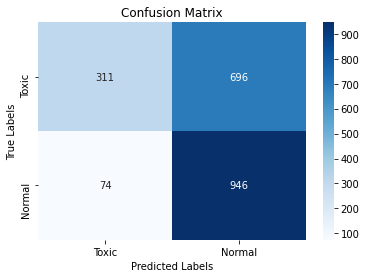

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import datetime

#시작 시간 설정
t0 = time.time()

y_pred = []
y_true = []

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= None,
                        attention_mask=batch[1])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[2].to('cpu').numpy()
    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(batch[2].tolist())

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxic', 'Normal'])
ax.yaxis.set_ticklabels(['Toxic', 'Normal']);

In [ ]:
# 입력 데이터 변환
def convert_input_data(sentence, model_type='roberta'):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = tokenizer(sentence,max_length=max_len, pad_to_max_length=True,  return_attention_mask=False)
    #tokenized_texts = tokenizer(sentence, padding='max_length', return_attention_mask=False)

    # 토큰을 숫자 인덱스로 변환
    input_ids = tokenized_texts['input_ids']
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    #input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)
    if model_type == 'squeeze':
        token_id = torch.tensor(tokenized_texts['token_type_ids'])
        return inputs, token_id, masks

    return inputs, masks

In [ ]:
def test_sentences(sentence, model_type='roberta'):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    if model_type == 'squeeze':
        inputs, token_id, masks  = convert_input_data(sentence)
    else:
        inputs, masks = convert_input_data(sentence)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
    if model_type == 'squeeze':
        b_token_id = token_id.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=b_token_id if model == 'squeeze' else None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
from keras.preprocessing.sequence import pad_sequences

start_time = time.time()
logits = test_sentences(['how do you think of gay'],['they are disgusting'])

print(logits)
print(np.argmax(logits))
print('test took', time.time()-start_time)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[ 2.1351507 -2.1156695]]
0
test took 1.8438951969146729


In [ ]:
start_time = time.time()
logits = test_sentences(['how do you think of gay'])

print(logits)
print(np.argmax(logits))
print('test took', time.time()-start_time)

[[ 2.1351507 -2.1156695]]
0
test took 0.027683019638061523


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
start_time = time.time()
logits = test_sentences(['its too hot outside'],['take off your jacket'])

print(logits)
print(np.argmax(logits))
print('test took', time.time()-start_time)

[[ 2.187334  -2.1743002]]
0
test took 0.027729272842407227


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
start_time = time.time()
logits = test_sentences(['hi im highschool student'],['hi take off your skirt for me'])

print(logits)
print(np.argmax(logits))
print('test took', time.time()-start_time)

[[ 2.1903708 -2.1826022]]
0
test took 0.026694774627685547


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


#Test on self dataset - best val auc



In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech", num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/context_2/E-17-VL-1.1257/pytorch_model.bin')
model.load_state_dict(state_dict)
model = model.to(device)

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
test = torch_dataset(X_test.map(encode), y_test)
test_loader = D.DataLoader(test, shuffle=False, batch_size=batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



Accuracy: 0.63
Test took: 0:00:15
Classification Report:
              precision    recall  f1-score   support

           1     0.7846    0.3545    0.4884      1007
           0     0.5865    0.9039    0.7114      1020

    accuracy                         0.6310      2027
   macro avg     0.6856    0.6292    0.5999      2027
weighted avg     0.6849    0.6310    0.6006      2027



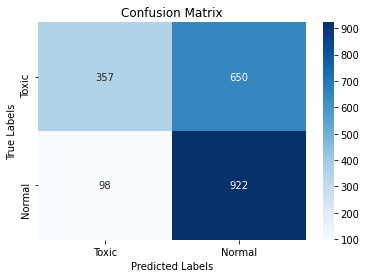

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import datetime

#시작 시간 설정
t0 = time.time()

y_pred = []
y_true = []

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= None,
                        attention_mask=batch[1])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[2].to('cpu').numpy()
    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(batch[2].tolist())

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxic', 'Normal'])
ax.yaxis.set_ticklabels(['Toxic', 'Normal']);

In [ ]:
# 입력 데이터 변환
def convert_input_data(sentence, model_type='roberta'):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = tokenizer(sentence,max_length=max_len, pad_to_max_length=True,  return_attention_mask=False)
    #tokenized_texts = tokenizer(sentence, padding='max_length', return_attention_mask=False)

    # 토큰을 숫자 인덱스로 변환
    input_ids = tokenized_texts['input_ids']
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    #input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)
    if model_type == 'squeeze':
        token_id = torch.tensor(tokenized_texts['token_type_ids'])
        return inputs, token_id, masks

    return inputs, masks

In [ ]:
def test_sentences(sentence, model_type='roberta'):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    if model_type == 'squeeze':
        inputs, token_id, masks  = convert_input_data(sentence)
    else:
        inputs, masks = convert_input_data(sentence)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
    if model_type == 'squeeze':
        b_token_id = token_id.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=b_token_id if model == 'squeeze' else None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
from keras.preprocessing.sequence import pad_sequences

start_time = time.time()
logits = test_sentences(['how do you think of gay'],['they are disgusting'])

print(logits)
print(np.argmax(logits))
print('test took', time.time()-start_time)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[ 2.8046346 -2.7706363]]
0
test took 1.6769623756408691


In [ ]:
start_time = time.time()
logits = test_sentences(['how do you think of gay'])

print(logits)
print(np.argmax(logits))
print('test took', time.time()-start_time)

[[ 2.8046346 -2.7706363]]
0
test took 0.024840593338012695


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
start_time = time.time()
logits = test_sentences(['its too hot outside'],['take off your jacket'])

print(logits)
print(np.argmax(logits))
print('test took', time.time()-start_time)

[[ 2.9415488 -2.931316 ]]
0
test took 0.025151491165161133


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
start_time = time.time()
logits = test_sentences(['hi im highschool student'],['hi take off your skirt for me'])

print(logits)
print(np.argmax(logits))
print('test took', time.time()-start_time)

[[ 2.9374356 -2.9706721]]
0
test took 0.023713111877441406


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


#Test on self dataset - lowest val loss



In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-tweets-hate-speech", num_labels=2)
state_dict = torch.load('/content/drive/MyDrive/finalproject/context_2/E-49-VL-0.7765/pytorch_model.bin')
model.load_state_dict(state_dict)
model = model.to(device)

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
test = torch_dataset(X_test.map(encode), y_test)
test_loader = D.DataLoader(test, shuffle=False, batch_size=batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



Accuracy: 0.62
Test took: 0:00:09
Classification Report:
              precision    recall  f1-score   support

           1     0.8031    0.3118    0.4492      1007
           0     0.5764    0.9245    0.7101      1020

    accuracy                         0.6201      2027
   macro avg     0.6897    0.6182    0.5797      2027
weighted avg     0.6890    0.6201    0.5805      2027



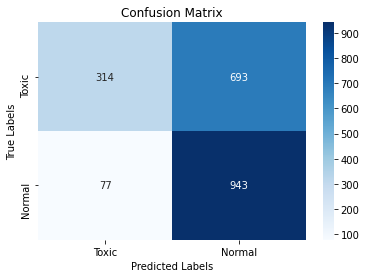

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import datetime

#시작 시간 설정
t0 = time.time()

y_pred = []
y_true = []

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_loader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_loader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(input_ids=batch[0],
                        token_type_ids= None,
                        attention_mask=batch[1])
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = batch[2].to('cpu').numpy()
    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(batch[2].tolist())

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Toxic', 'Normal'])
ax.yaxis.set_ticklabels(['Toxic', 'Normal']);

In [ ]:
# 입력 데이터 변환
def convert_input_data(sentence, model_type='roberta'):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = tokenizer(sentence,max_length=max_len, pad_to_max_length=True,  return_attention_mask=False)
    #tokenized_texts = tokenizer(sentence, padding='max_length', return_attention_mask=False)

    # 토큰을 숫자 인덱스로 변환
    input_ids = tokenized_texts['input_ids']
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    #input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)
    if model_type == 'squeeze':
        token_id = torch.tensor(tokenized_texts['token_type_ids'])
        return inputs, token_id, masks

    return inputs, masks

In [ ]:
def test_sentences(sentence, model_type='roberta'):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    if model_type == 'squeeze':
        inputs, token_id, masks  = convert_input_data(sentence)
    else:
        inputs, masks = convert_input_data(sentence)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
    if model_type == 'squeeze':
        b_token_id = token_id.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=b_token_id if model == 'squeeze' else None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
from keras.preprocessing.sequence import pad_sequences

start_time = time.time()
logits = test_sentences(['how do you think of gay'],['they are disgusting'])

print(logits)
print(np.argmax(logits))
print('test took', time.time()-start_time)

[[ 2.2433975 -2.2157412]]
0
test took 0.024471282958984375


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
start_time = time.time()
logits = test_sentences(['how do you think of gay'])

print(logits)
print(np.argmax(logits))
print('test took', time.time()-start_time)

[[ 2.2433975 -2.2157412]]
0
test took 0.024219751358032227


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
start_time = time.time()
logits = test_sentences(['its too hot outside'],['take off your jacket'])

print(logits)
print(np.argmax(logits))
print('test took', time.time()-start_time)

[[ 2.2952642 -2.2743096]]
0
test took 0.024502277374267578


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
start_time = time.time()
logits = test_sentences(['hi im highschool student'],['hi take off your skirt for me'])

print(logits)
print(np.argmax(logits))
print('test took', time.time()-start_time)

[[ 2.304404  -2.2912252]]
0
test took 0.023781299591064453


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
